In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
import datetime

import joblib

In [5]:
inlocal = True

if inlocal:
  path = '.'
else:
  path = '/content/drive/MyDrive/projectML'

def plot_lr_vs_loss(rates, losses):
    plt.figure(figsize=(10, 5))
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

def create_callbacks(early_patience=25, model_name='model'):
  early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=early_patience, 
    restore_best_weights=True,
    monitor='val_accuracy',
  )
  checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f'{path}/models/checkpoints/{model_name}_best.h5',
    save_best_only=True, 
    save_weights_only=True,
    monitor='val_accuracy',
    overwrite=True,
  )
  logdir = f'{path}/logs/{model_name}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_cb = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  return early_stopping_cb, checkpoint_cb, tensorboard_cb

def plot_learning_curves(history):
  # accuracy vs epoch
  plt.figure(figsize=(10, 6),dpi=100)
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='val')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.hlines(max(history.history['val_accuracy']), 0, len(history.history['val_accuracy']), colors='r', linestyles='dashed', label='max val acc')
  plt.hlines(max(history.history['accuracy']), 0, len(history.history['accuracy']), colors='g', linestyles='dashed', label='max train acc')
  plt.grid()
  plt.legend()
  plt.show()
  
  # loss vs epoch
  plt.figure(figsize=(10, 6),dpi=100)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='val')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.hlines(min(history.history['val_loss']), 0, len(history.history['val_loss']), colors='r', linestyles='dashed', label='min val loss')
  plt.hlines(min(history.history['loss']), 0, len(history.history['loss']), colors='g', linestyles='dashed', label='min train loss')
  plt.grid()
  plt.legend()
  plt.show()


def load_best_model(model, model_name='model'):
  model.load_weights(f'{path}/models/checkpoints/{model_name}_best.h5')
  return model

In [4]:
if not inlocal:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
target = 'Credit_Score'
if inlocal:
  train = pd.read_csv('../data/cleaned/train.csv')
  val = pd.read_csv('../data/cleaned/val.csv')
  test = pd.read_csv('../data/cleaned/test.csv')
else: 
  train = pd.read_csv('/content/drive/MyDrive/projectML/Data/train.csv')
  val = pd.read_csv('/content/drive/MyDrive/projectML/Data/val.csv')
  test = pd.read_csv('/content/drive/MyDrive/projectML/Data/test.csv')


X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]
X_test, y_test = test.drop(target, axis=1), test[target]

print('Train set: ', X_train.shape, y_train.shape)
print('Validation set: ', X_val.shape, y_val.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (74997, 55) (74997,)
Validation set:  (15003, 55) (15003,)
Test set:  (10000, 55) (10000,)


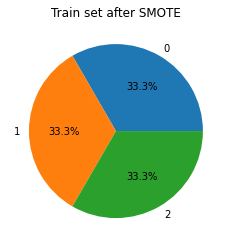

In [7]:
col_transformer = ColumnTransformer([
    ('num', StandardScaler(), X_train.select_dtypes(include=np.float64).columns),
], remainder='passthrough')
X_train = col_transformer.fit_transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42,k_neighbors=90)
X_train, y_train = smote.fit_resample(X_train, y_train)
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%')
plt.title('Train set after SMOTE')
plt.show()

### Model 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


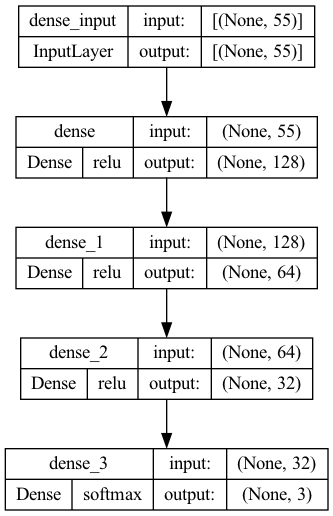

In [8]:
def create_model1(learning_rate=1e-3):
  tf.random.set_seed(42)
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(128, input_shape=[X_train.shape[1]],activation='relu'),
      layers.Dense(64,activation='relu'),
      layers.Dense(32,activation='relu'),
      layers.Dense(3,activation='softmax')
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model

model1 = create_model1()
model1.summary()
keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model1_history = model1.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model1'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/300
3739/3739 [==============================] - 6s 1ms/step - loss: 0.6463 - accuracy: 0.7329 - val_loss: 0.7189 - val_accuracy: 0.6704
Epoch 2/300
3739/3739 [==============================] - 5s 1ms/step - loss: 0.5811 - accuracy: 0.7579 - val_loss: 0.6867 - val_accuracy: 0.6889
Epoch 3/300
3739/3739 [==============================] - 5s 1ms/step - loss: 0.5402 - accuracy: 0.7750 - val_loss: 0.7074 - val_accuracy: 0.6833
Epoch 4/300
3739/3739 [==============================] - 5s 1ms/step - loss: 0.5054 - accuracy: 0.7905 - val_loss: 0.6884 - val_accuracy: 0.6890
Epoch 5/300
3739/3739 [==============================] - 5s 1ms/step - loss: 0.4765 - accuracy: 0.8024 - val_loss: 0.6546 - val_accuracy: 0.7059
Epoch 6/300
3739/3739 [==============================] - 5s 1ms/step - loss: 0.4522 - accuracy: 0.8119 - val_loss: 0.6493 - val_accuracy: 0.7119
Epoch 7/300
3739/3739 [==============================] - 7s 2ms/step - loss: 0.4317 - accuracy: 0.8204 - val_loss: 0.6479 - val_ac

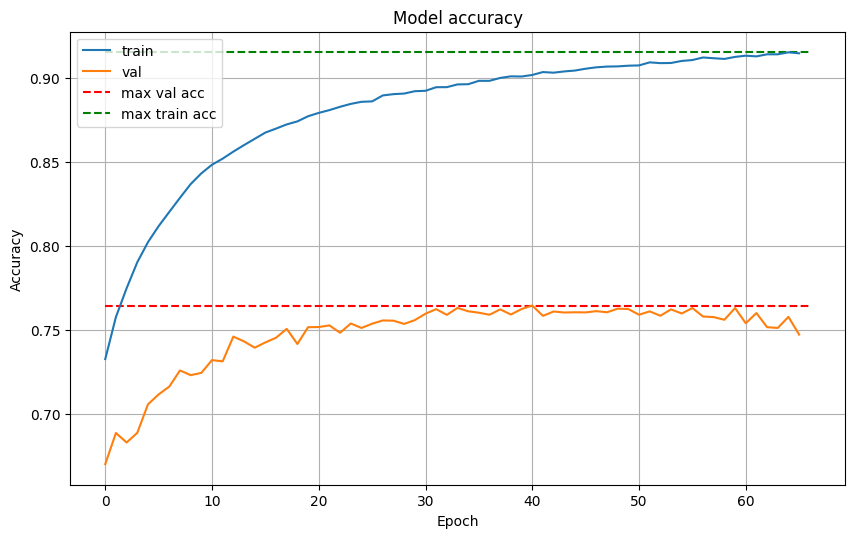

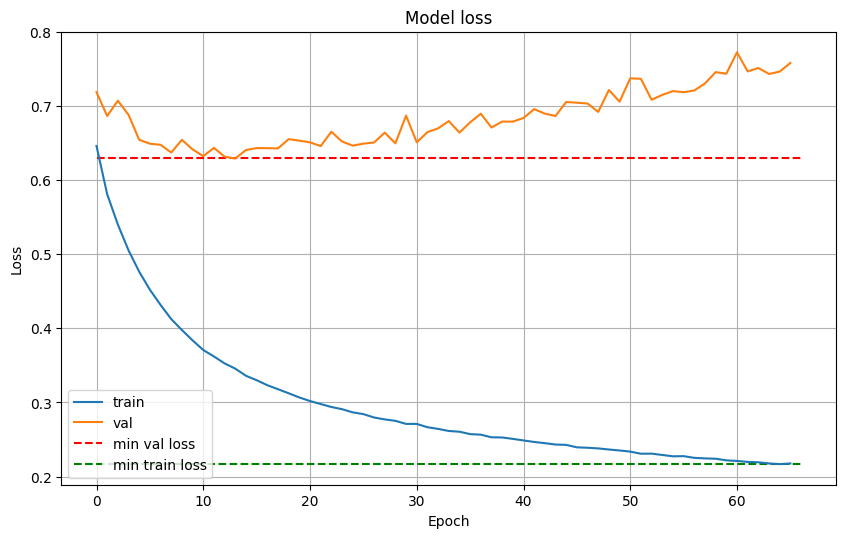

In [ ]:
plot_learning_curves(model1_history)

In [ ]:
model1 = load_best_model(create_model1(), 'model1')
model1.evaluate(X_val,y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.6841 - accuracy: 0.7647


[0.6840555667877197, 0.764713704586029]

### Model 2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64)                0

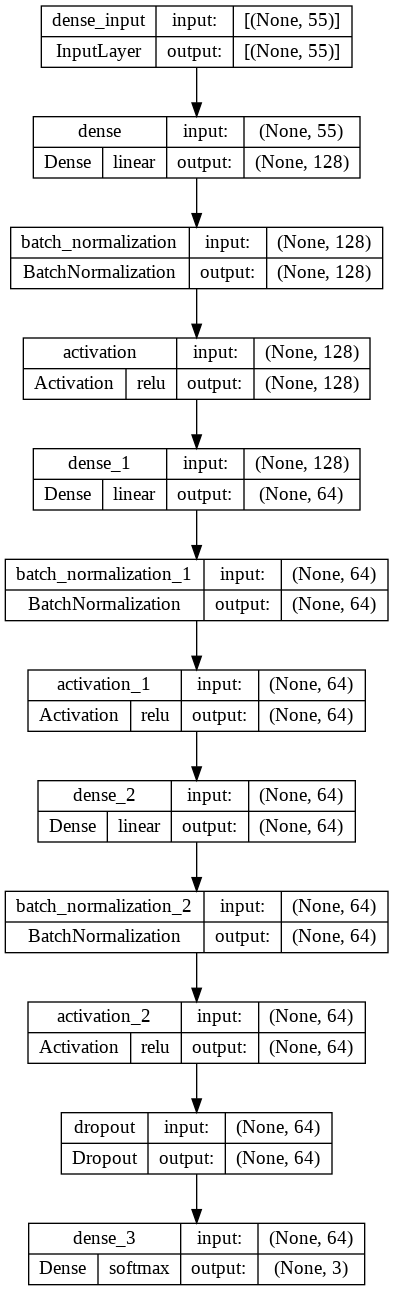

In [ ]:
def create_model2(learning_rate=1e-3):
  tf.random.set_seed(42)
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(128, input_shape=[X_train.shape[1]]),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dropout(0.2),
      layers.Dense(3,activation='softmax')
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model
model2 = create_model2(1e-3)
model2.summary()
keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model2_history = model2.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(30, 'model2'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/300
3739/3739 [==============================] - 9s 2ms/step - loss: 0.6834 - accuracy: 0.7191 - val_loss: 0.7130 - val_accuracy: 0.6791
Epoch 2/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.6240 - accuracy: 0.7407 - val_loss: 0.6944 - val_accuracy: 0.6822
Epoch 3/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.5942 - accuracy: 0.7510 - val_loss: 0.7055 - val_accuracy: 0.6835
Epoch 4/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.5695 - accuracy: 0.7614 - val_loss: 0.6842 - val_accuracy: 0.6928
Epoch 5/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.5543 - accuracy: 0.7672 - val_loss: 0.6535 - val_accuracy: 0.7003
Epoch 6/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.5394 - accuracy: 0.7737 - val_loss: 0.6492 - val_accuracy: 0.7062
Epoch 7/300
3739/3739 [==============================] - 8s 2ms/step - loss: 0.5269 - accuracy: 0.7775 - val_loss: 0.6470 - val_ac

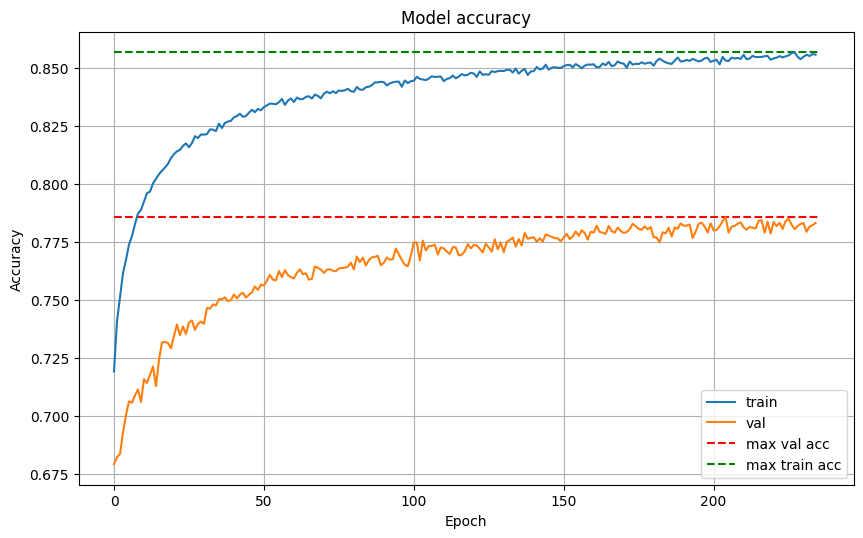

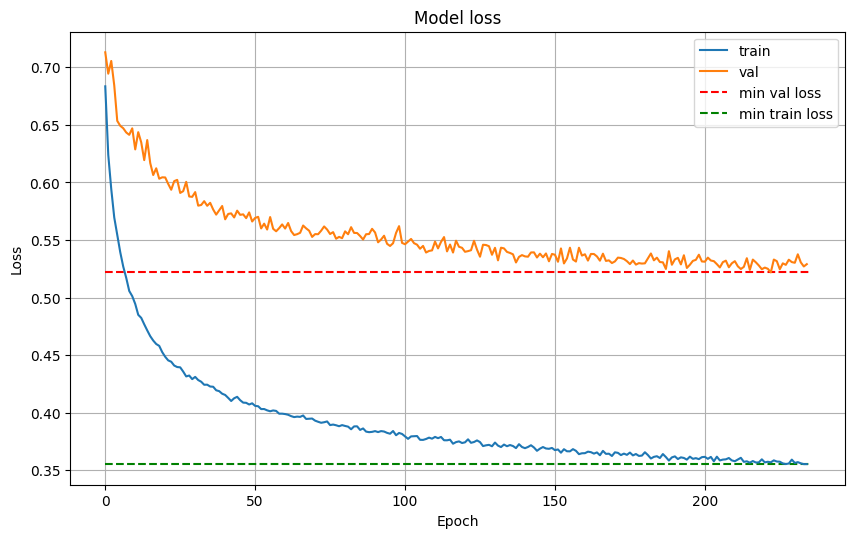

In [ ]:
plot_learning_curves(model2_history)

In [ ]:
model2 = load_best_model(create_model2(), 'model2')
model2.evaluate(X_val,y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.5290 - accuracy: 0.7856


[0.5290418863296509, 0.7855762243270874]

### Model 3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14336     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0

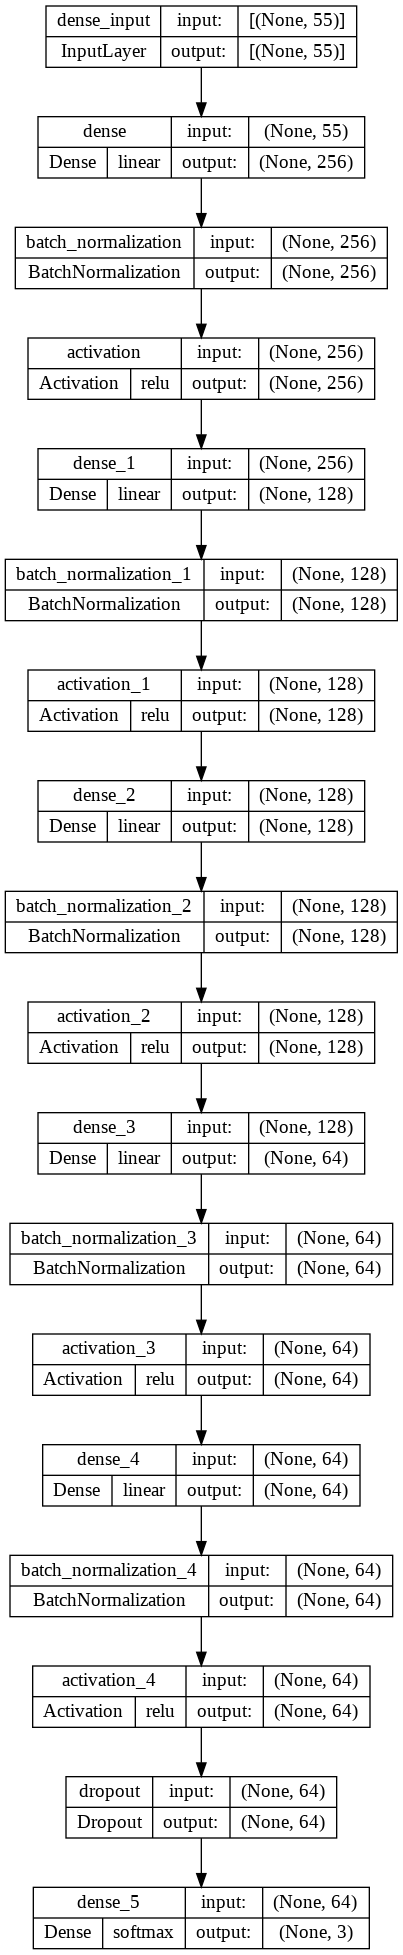

In [11]:
def create_model3(learning_rate=1e-3):
  tf.random.set_seed(42)
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(256, input_shape=[X_train.shape[1]]),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dropout(0.25),
      layers.Dense(3,activation='softmax')
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model
model3 = create_model3()
model3.summary()
keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model3_history = model3.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model3'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/300
3739/3739 [==============================] - 13s 3ms/step - loss: 0.6829 - accuracy: 0.7204 - val_loss: 0.7113 - val_accuracy: 0.6854
Epoch 2/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.6138 - accuracy: 0.7449 - val_loss: 0.6787 - val_accuracy: 0.6856
Epoch 3/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.5690 - accuracy: 0.7639 - val_loss: 0.6761 - val_accuracy: 0.6923
Epoch 4/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.5337 - accuracy: 0.7778 - val_loss: 0.6578 - val_accuracy: 0.7028
Epoch 5/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.5062 - accuracy: 0.7883 - val_loss: 0.6386 - val_accuracy: 0.7066
Epoch 6/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.4822 - accuracy: 0.7986 - val_loss: 0.6300 - val_accuracy: 0.7140
Epoch 7/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.4605 - accuracy: 0.8067 - val_loss: 0.6077 -

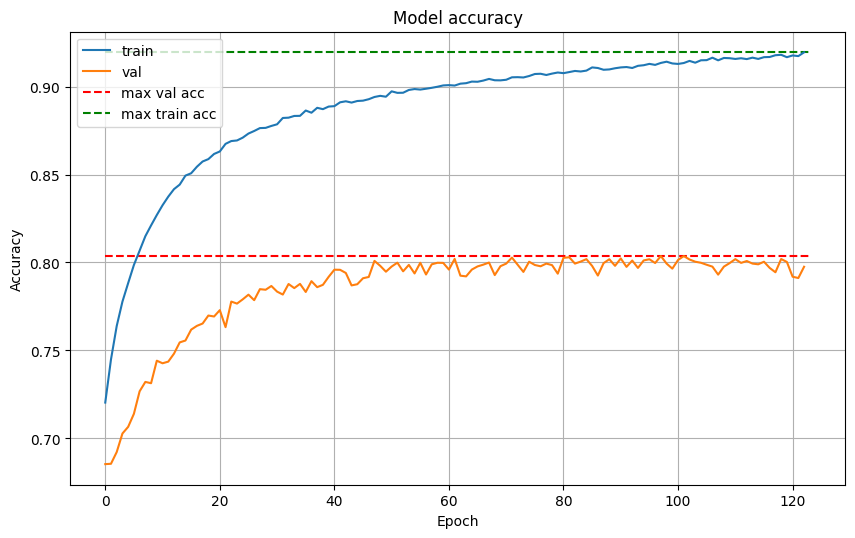

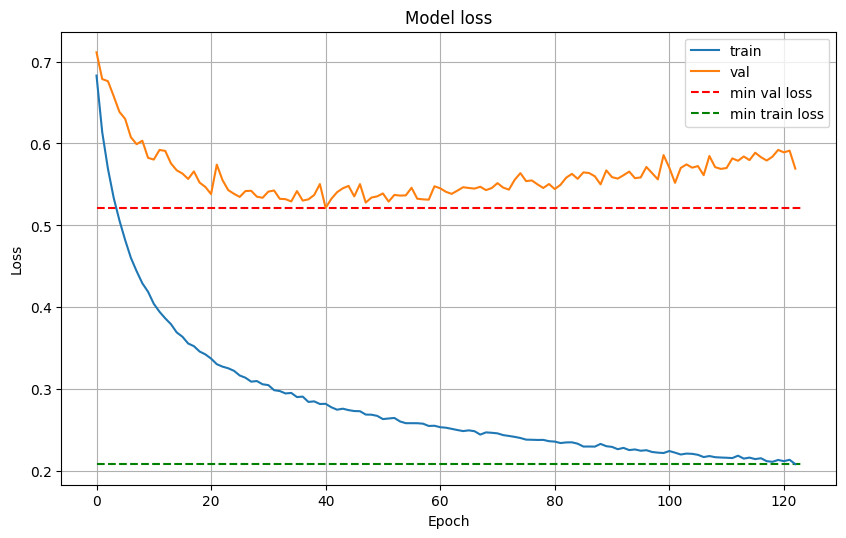

In [ ]:
plot_learning_curves(model3_history)

In [ ]:
model3 = load_best_model(create_model3(), 'model3')
model3.evaluate(X_val, y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.5638 - accuracy: 0.8036


[0.5637912154197693, 0.80363929271698]

### Model 4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0

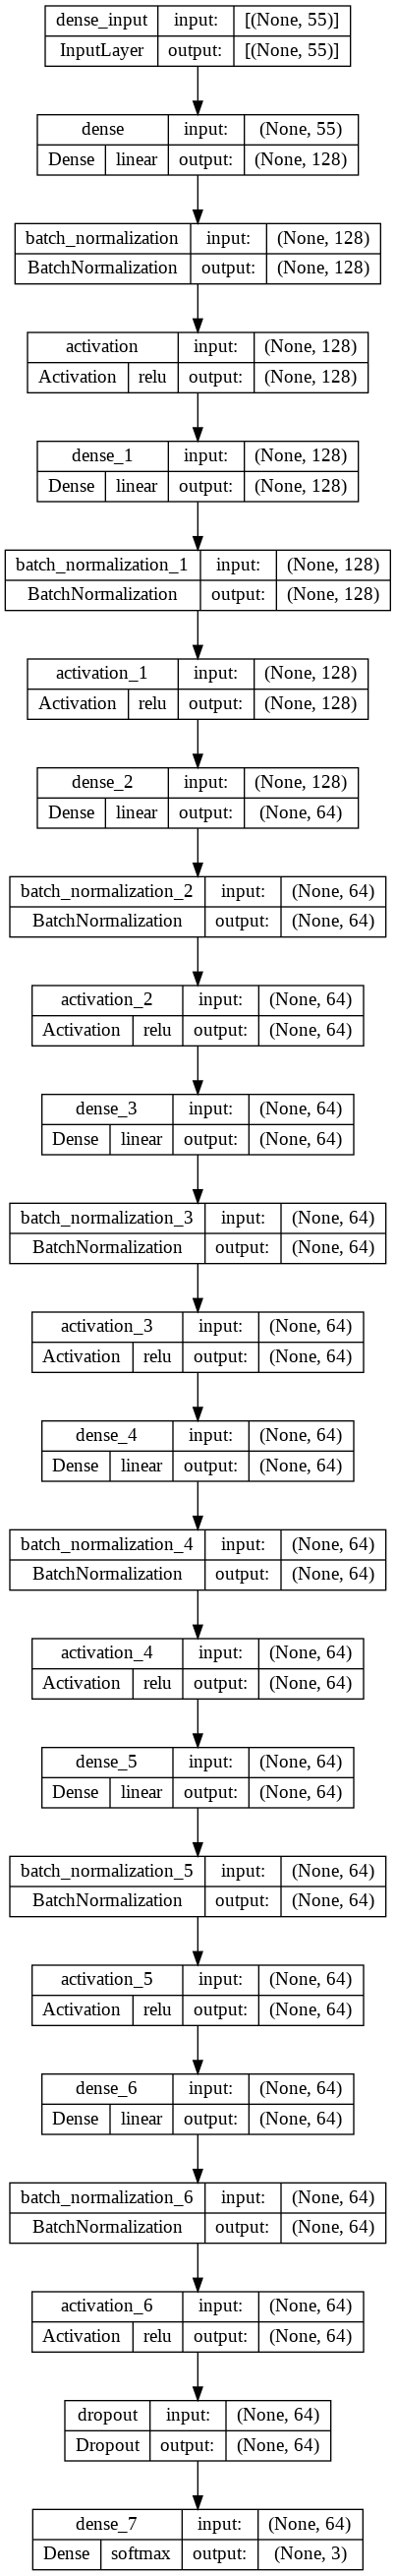

In [12]:
def create_model4(learning_rate=1e-3):
  tf.random.set_seed(42)
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(128, input_shape=[X_train.shape[1]]),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dropout(0.25),
      layers.Dense(3,activation='softmax')
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model
model4 = create_model4()
model4.summary()
keras.utils.plot_model(model4, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model4_history = model4.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model4'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/300
3739/3739 [==============================] - 13s 3ms/step - loss: 0.7099 - accuracy: 0.7079 - val_loss: 0.7444 - val_accuracy: 0.6639
Epoch 2/300
3739/3739 [==============================] - 12s 3ms/step - loss: 0.6367 - accuracy: 0.7366 - val_loss: 0.6859 - val_accuracy: 0.6822
Epoch 3/300
3739/3739 [==============================] - 12s 3ms/step - loss: 0.6019 - accuracy: 0.7495 - val_loss: 0.6975 - val_accuracy: 0.6849
Epoch 4/300
3739/3739 [==============================] - 12s 3ms/step - loss: 0.5702 - accuracy: 0.7630 - val_loss: 0.6918 - val_accuracy: 0.6858
Epoch 5/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.5498 - accuracy: 0.7729 - val_loss: 0.6561 - val_accuracy: 0.6973
Epoch 6/300
3739/3739 [==============================] - 12s 3ms/step - loss: 0.5273 - accuracy: 0.7814 - val_loss: 0.6347 - val_accuracy: 0.7137
Epoch 7/300
3739/3739 [==============================] - 11s 3ms/step - loss: 0.5101 - accuracy: 0.7881 - val_loss: 0.6302 -

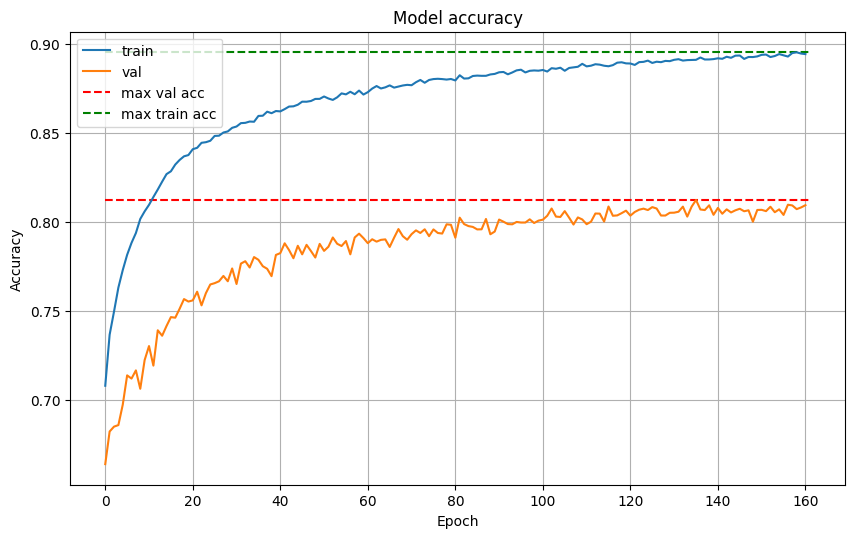

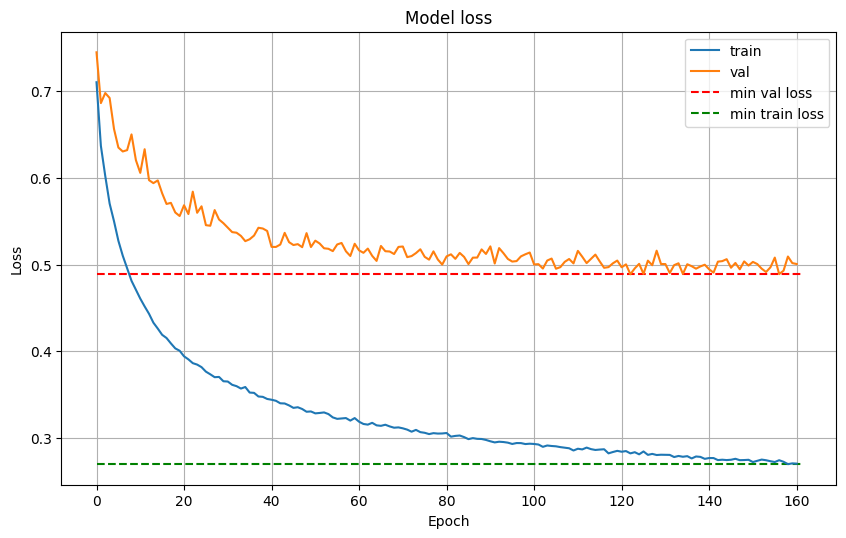

In [ ]:
plot_learning_curves(model4_history)

In [ ]:
model4 = load_best_model(create_model4(), 'model4')
model4.evaluate(X_val, y_val)

469/469 [==============================] - 1s 2ms/step - loss: 0.5003 - accuracy: 0.8122


[0.5003101825714111, 0.812237560749054]

### Model 5

In [13]:
def create_model5(learning_rate=1e-3):
  tf.random.set_seed(42)
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(256, input_shape=[X_train.shape[1]]),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      
      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      
      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dropout(0.25),
      layers.Dense(3,activation='softmax')
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model
model5 = create_model5()
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14336     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0

In [ ]:
model5_history = model5.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model5'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/300
3739/3739 [==============================] - 15s 4ms/step - loss: 0.6989 - accuracy: 0.7135 - val_loss: 0.7280 - val_accuracy: 0.6743
Epoch 2/300
3739/3739 [==============================] - 14s 4ms/step - loss: 0.6319 - accuracy: 0.7390 - val_loss: 0.7003 - val_accuracy: 0.6797
Epoch 3/300
3739/3739 [==============================] - 14s 4ms/step - loss: 0.5891 - accuracy: 0.7571 - val_loss: 0.7047 - val_accuracy: 0.6885
Epoch 4/300
3739/3739 [==============================] - 14s 4ms/step - loss: 0.5512 - accuracy: 0.7715 - val_loss: 0.6659 - val_accuracy: 0.6982
Epoch 5/300
3739/3739 [==============================] - 14s 4ms/step - loss: 0.5245 - accuracy: 0.7819 - val_loss: 0.6321 - val_accuracy: 0.7093
Epoch 6/300
3739/3739 [==============================] - 14s 4ms/step - loss: 0.4971 - accuracy: 0.7932 - val_loss: 0.6268 - val_accuracy: 0.7190
Epoch 7/300
3739/3739 [==============================] - 13s 4ms/step - loss: 0.4749 - accuracy: 0.8025 - val_loss: 0.6093 -

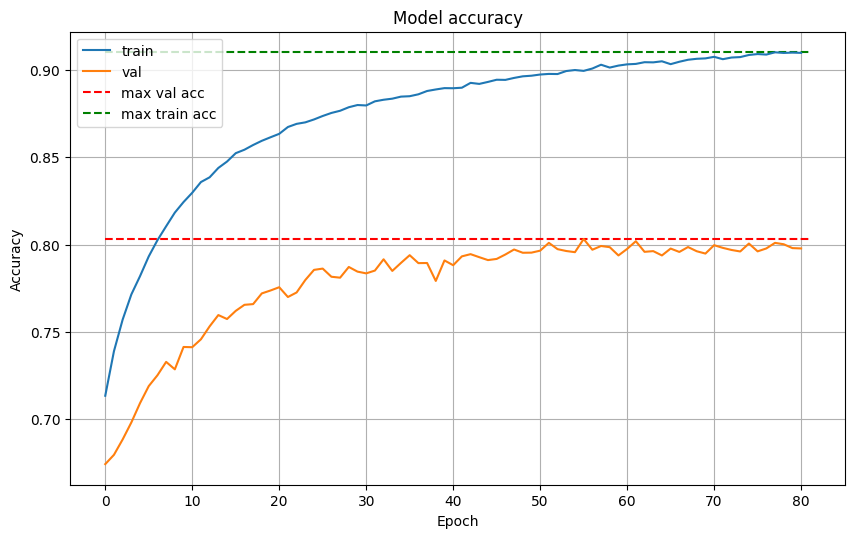

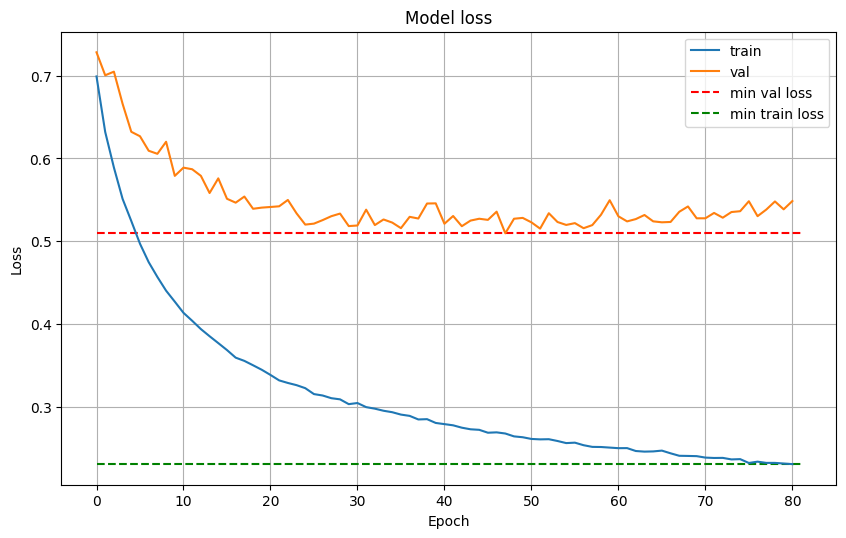

In [ ]:
plot_learning_curves(model5_history)

In [ ]:
model5 = load_best_model(create_model5(), 'model5')
model5.evaluate(X_val, y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.8032


[0.5220024585723877, 0.8031727075576782]

### Model 6

In [14]:
def create_model6():
    tf.random.set_seed(42)
    keras.backend.clear_session()
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]], kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dense(3, activation='softmax',kernel_regularizer=keras.regularizers.l2(1e-4))
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

In [ ]:
model6 = create_model6()
model6.summary()
model6_history = model6.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model6'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 36,291
Trainable params: 36,291
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
3739/3739 [=============================

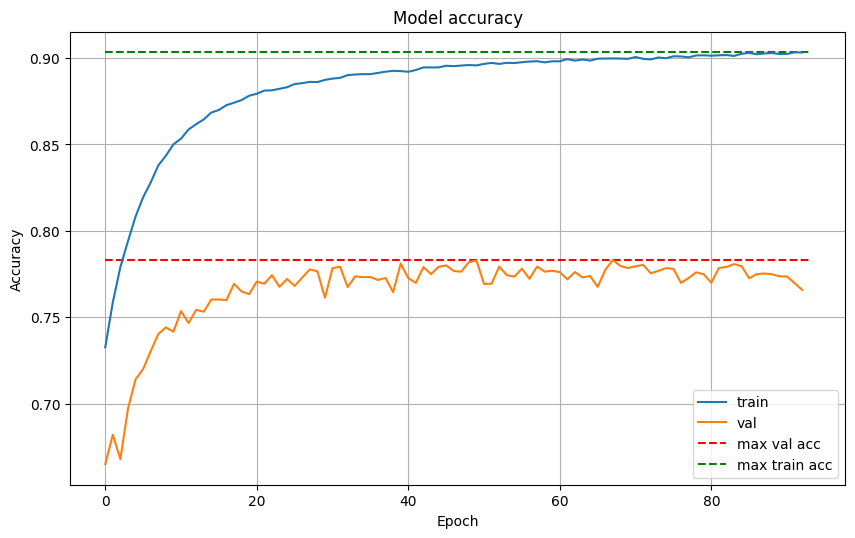

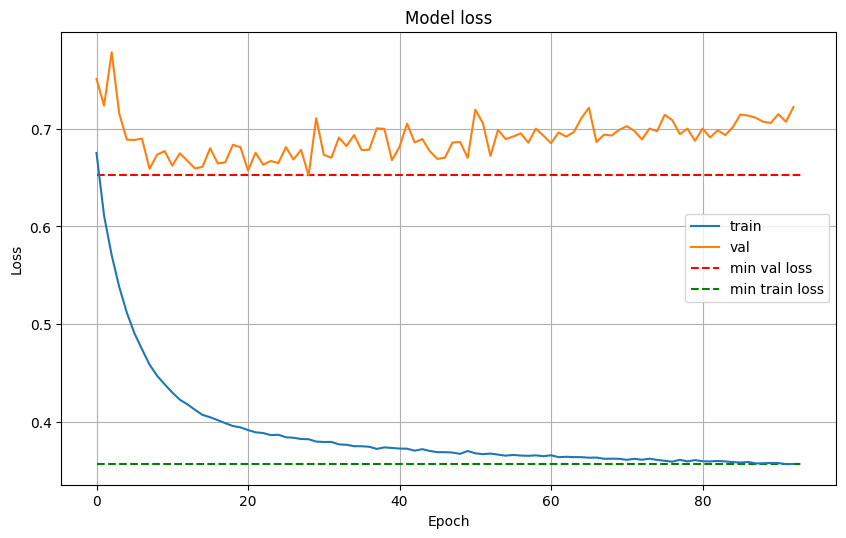

In [ ]:
plot_learning_curves(model6_history)

In [ ]:
model6 = load_best_model(create_model6(), 'model6')
model6.evaluate(X_val, y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.6939 - accuracy: 0.7832


[0.6938971877098083, 0.7831767201423645]

### Model 7

In [ ]:
def create_model7():
  tf.random.set_seed(42)    
  keras.backend.clear_session()
  model = keras.Sequential([
      layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]], kernel_regularizer=keras.regularizers.l2(5*1e-4)),
      layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(5*1e-4)),
      layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(5*1e-4)),
      layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(5*1e-4)),
      layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(5*1e-4)),
      layers.Dense(3, activation='softmax',kernel_regularizer=keras.regularizers.l2(5*1e-4))
  ])
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      metrics=['accuracy']
  )
  return model

In [ ]:
model7 = create_model7()
model7.summary()
model7_history = model7.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[
        *create_callbacks(25, 'model7'),
    ],
    validation_data=(X_val, y_val),
    verbose=1,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 28,099
Trainable params: 28,099
Non-traina

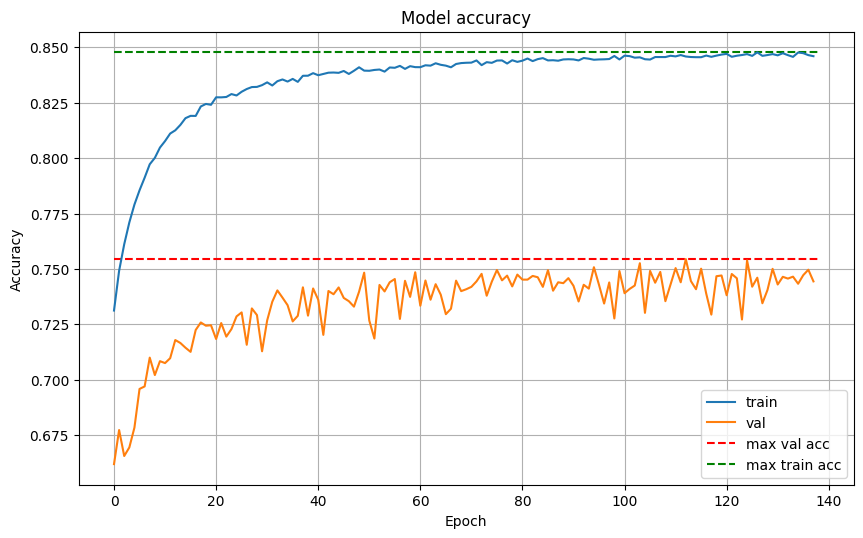

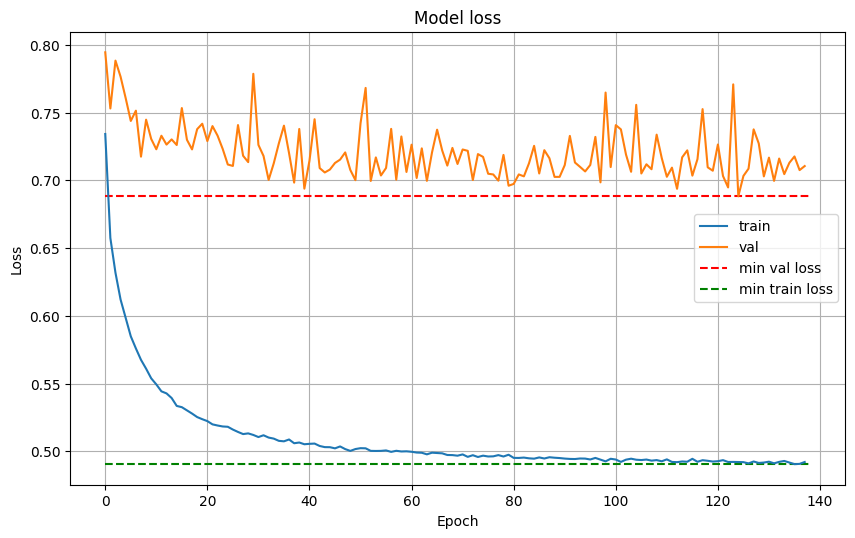

In [ ]:
plot_learning_curves(model7_history)

In [ ]:
model7 = load_best_model(create_model7(), 'model7')
model7.evaluate(X_val, y_val)

469/469 [==============================] - 1s 1ms/step - loss: 0.6938 - accuracy: 0.7544


[0.6937534213066101, 0.7544491291046143]

### Model 8

In [16]:
# combine some good models
class CombinedModel():
  def __init__(self, ann_models, rf_models):
    self.ann_models = ann_models
    self.rf_models = rf_models

  def predict(self, X):
    ann_preds = 0
    if len(self.ann_models) > 0:
      ann_preds = np.mean([model.predict(X, verbose=0) for model in self.ann_models], axis=0)
    rf_preds = 0
    if len(self.rf_models) > 0:
      rf_preds = np.mean([model.predict_proba(X) for model in self.rf_models], axis=0)
    return np.argmax(ann_preds + rf_preds, axis=1)

## Evaluate on test set

In [11]:
def report(model_name, y_test, y_pred):
  print('Report for', model_name, ':\n\n', classification_report(y_test, y_pred))
  # plot confusion matrix
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title('Confusion matrix for ' + model_name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print(f'Accuracy of {model_name}: ', accuracy_score(y_test, y_pred))
  print('-'*60)
  print('\n\n\n')

In [7]:
et = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=8,
    random_state=42
)
et.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=7,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=7, n_estimators=200)

In [23]:
model3 = load_best_model(create_model3(), 'model3')
model4 = load_best_model(create_model4(), 'model4')
model5 = load_best_model(create_model5(), 'model5')
model6 = load_best_model(create_model6(), 'model6')

model8 = CombinedModel([model3, model4, model5], [et,rf])

In [24]:
y_pred_3 = model3.predict(X_test, verbose=0).argmax(axis=1)
y_pred_4 = model4.predict(X_test, verbose=0).argmax(axis=1)
y_pred_5 = model5.predict(X_test, verbose=0).argmax(axis=1)
y_pred_6 = model6.predict(X_test, verbose=0).argmax(axis=1)
y_pred_8 = model8.predict(X_test)

Report for model3 :

               precision    recall  f1-score   support

           0       0.77      0.87      0.82      2900
           1       0.86      0.78      0.82      5317
           2       0.76      0.80      0.78      1783

    accuracy                           0.81     10000
   macro avg       0.79      0.82      0.80     10000
weighted avg       0.81      0.81      0.81     10000



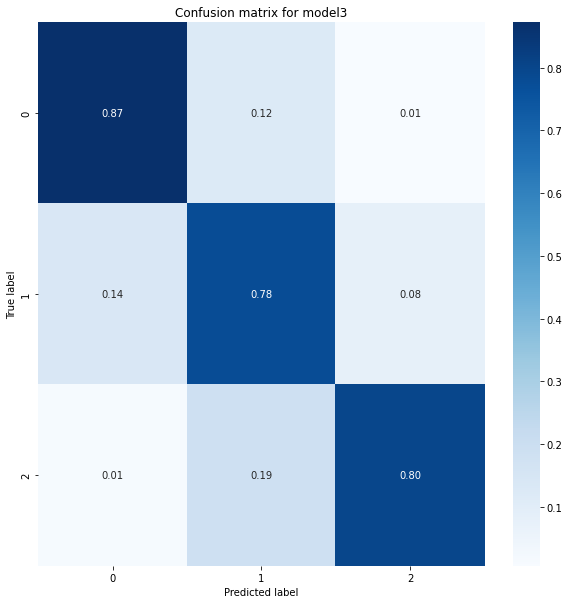

Accuracy of model3:  0.8098
------------------------------------------------------------




Report for model4 :

               precision    recall  f1-score   support

           0       0.77      0.88      0.83      2900
           1       0.88      0.77      0.82      5317
           2       0.75      0.86      0.80      1783

    accuracy                           0.82     10000
   macro avg       0.80      0.84      0.82     10000
weighted avg       0.83      0.82      0.82     10000



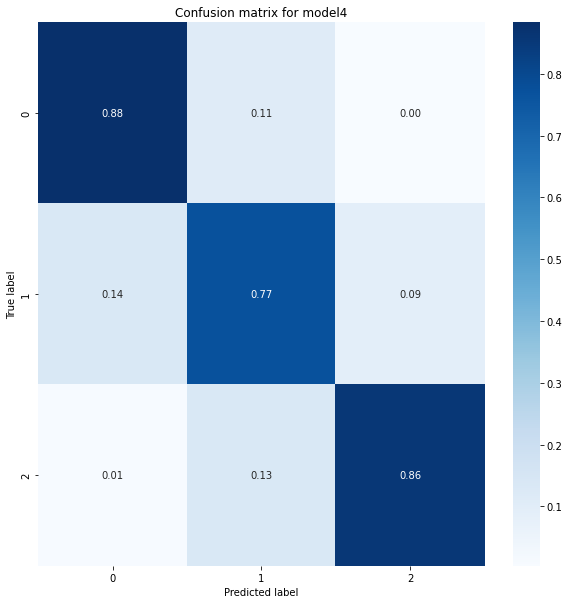

Accuracy of model4:  0.8188
------------------------------------------------------------




Report for model5 :

               precision    recall  f1-score   support

           0       0.76      0.85      0.81      2900
           1       0.85      0.77      0.81      5317
           2       0.74      0.82      0.78      1783

    accuracy                           0.80     10000
   macro avg       0.78      0.81      0.80     10000
weighted avg       0.81      0.80      0.80     10000



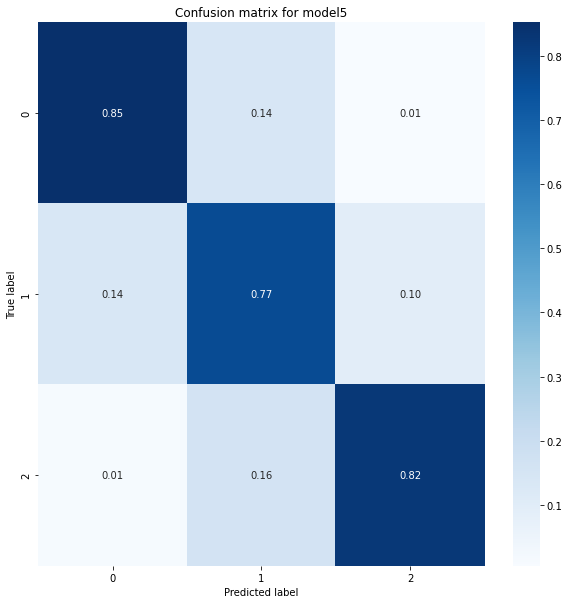

Accuracy of model5:  0.8007
------------------------------------------------------------




Report for model6 :

               precision    recall  f1-score   support

           0       0.76      0.81      0.78      2900
           1       0.82      0.77      0.79      5317
           2       0.73      0.76      0.74      1783

    accuracy                           0.78     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.78      0.78      0.78     10000



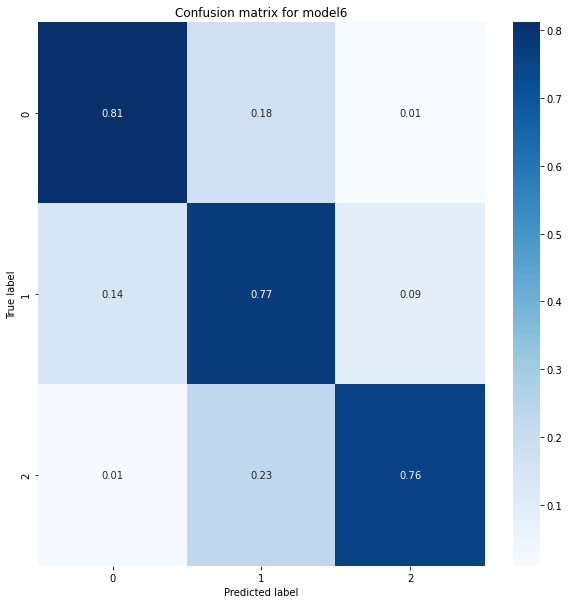

Accuracy of model6:  0.7814
------------------------------------------------------------




Report for model8 :

               precision    recall  f1-score   support

           0       0.80      0.89      0.84      2900
           1       0.88      0.80      0.84      5317
           2       0.78      0.86      0.82      1783

    accuracy                           0.84     10000
   macro avg       0.82      0.85      0.83     10000
weighted avg       0.84      0.84      0.84     10000



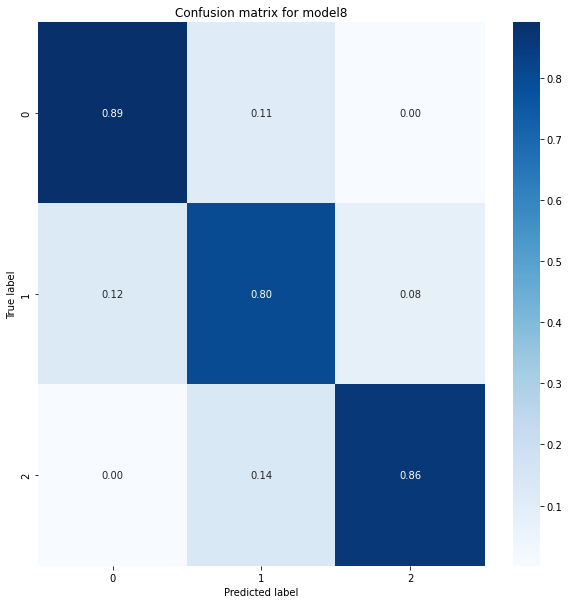

Accuracy of model8:  0.8362
------------------------------------------------------------






In [25]:
report('model3', y_test, y_pred_3)
report('model4', y_test, y_pred_4)
report('model5', y_test, y_pred_5)
report('model6', y_test, y_pred_6)
report('model8', y_test, y_pred_8)